# Import Library and Data


In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/CSNam3HUCEStudents/MachineLearning/NaiveBayesAndKMean/code/NaiveBayes

/content/drive/MyDrive/CSNam3HUCEStudents/MachineLearning/NaiveBayesAndKMean/code/NaiveBayes


In [3]:
import numpy as np
import codecs
import io
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

# Feature Engineering


In [4]:
def read_label_file(url):
  label_file = []
  with codecs.open(url, encoding='utf-8-sig') as f:
      for line in f:
        s = line.split()
        label_file.append( [str(s[i]) for i in range(len(s))] )

  return label_file

In [5]:
# doc file train va test label
train_y = read_label_file("traininglabels")
test_y = read_label_file("testlabels")

# chuyen file vua doc thanh array
train_y = np.array(train_y)
test_y = np.array(test_y)
train_y.shape

#chuyen kieu du lieu thanh int
train_y = train_y.astype('int32')
test_y = test_y.astype('int32')

In [6]:
def read_train_file(url):
  file = open(url)
  read_file = file.read()
  read_file = read_file.replace("\n","").replace("+","1").replace(" ","0").replace("#","1")
  return list(read_file)

In [7]:
# doc file train va test feature
train_X = read_train_file("trainingimages.txt")
test_X = read_train_file("testimages.txt")

# chuyen file vua doc sang array
train_X = np.array(train_X)
test_X = np.array(test_X)

In [8]:
# chuyen file train va test feature ve khong gian 3 chieu (so buc anh, chieu ngang buc anh, chieu doc buc anh)
train_X = train_X.astype('float32')
train_X = train_X.reshape(5000, 28, 28)
test_X = test_X.astype('float32')
test_X = test_X.reshape(1000, 28, 28)

# Training


## Naive Bayes

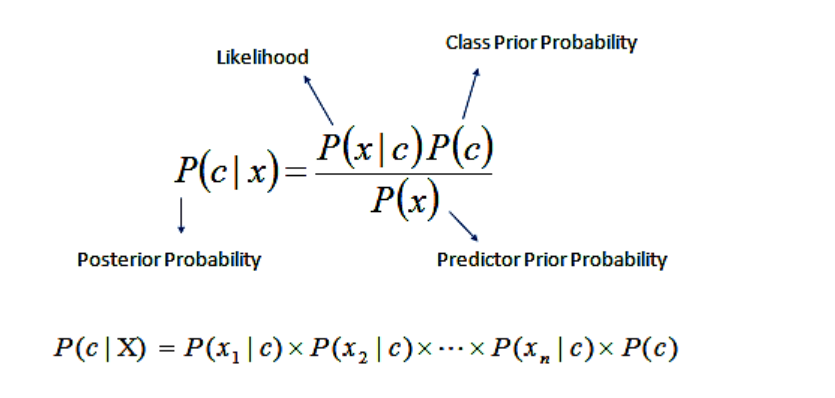

###Class prior probability

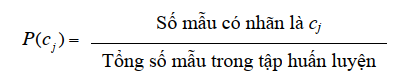

In [55]:
def find_P_class_i(train_y):
  # vector 1D gom 10 class (buc anh tu 0 den 9), dimension (10, )
  n_class = np.zeros((10))

  # class y chay tu 1 den 9
  for y in range(10):
    # tinh xem o class thu y se co bao nhieu buc anh
      n_class[y] = (train_y == y).sum()

      # tinh xac suat cua buc anh o class thu y xuat hien bao nhieu lan trong tap data
  P_class = n_class / n_class.sum()
  
  return (P_class, n_class)

In [56]:
P_class, n_class = find_P_class_i(train_y)

### Likelihood

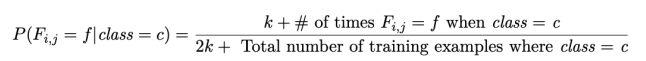

In [57]:
def laplace_smoothing(n_class, train_y, train_X):
  # tham so laplace
  k = 10**(-8)

  # 10 ma tran 28x28 tuong ung voi 10 class
  feature_matrices = np.zeros((10, 28, 28))
  
  for y in range(10):
    # the likelihoods that a feature Fi,j has value f ∈ {0,1} as we have binary features
    # given that the current image is of class c ∈ {0, 1, ..., 9}
    # each feature matrix represents each class c
    # train_y from (5000,1) -> (5000,)
    feature_matrices[y] =  train_X[train_y.reshape(5000) == y].sum(axis=0) 
  
  # (10, 28, 28) / (10, 1, 1)
  P_laplace = (k + feature_matrices) / (2*k + n_class).reshape(10, 1, 1)
  return P_laplace

In [58]:
P_laplace = laplace_smoothing(n_class, train_y, train_X)
# 10^-10  : accu = 0.776
# 10^-8   : accu = 0.777
# 10^-6   : accu = 0.776
# 10^-4   : accu = 0.775
# 10^-2   : accu = 0.774
# 1       : accu = 0.771

# với tập train: 
# 1       : accu = 0.84

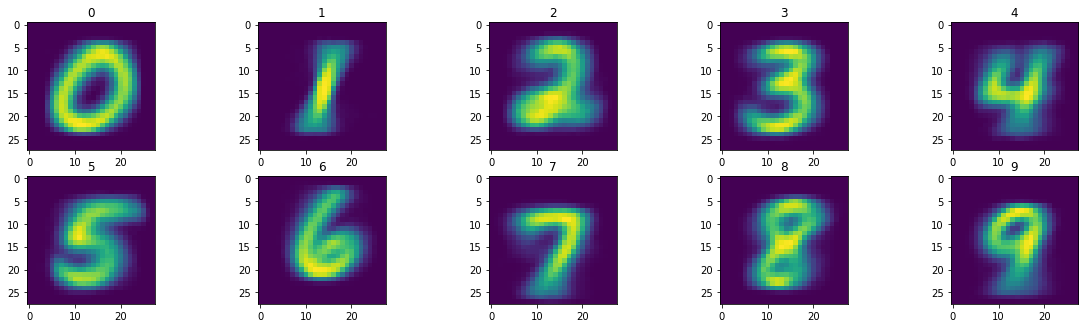

In [59]:
# Plotting
fig = plt.figure(figsize=(20,8))
for i in range(10):  
    ax = fig.add_subplot(3, 5, i+1)
    ax.imshow(P_laplace[i])
    ax.set_title(i)

# Save and Load model

In [98]:
import h5py
h5f = h5py.File('data1.h5', 'w')
h5f.create_dataset('dataset_1', data=P_laplace.reshape(10, 28*28))

<HDF5 dataset "dataset_1": shape (10, 784), type "<i8">

In [101]:
h5f = h5py.File('data.h5','r')
P_laplace = h5f['dataset_1'][:]

In [ ]:
P_laplace = P_laplace.reshape(10, 28, 28)

# Classifying

## Bernoulli distribution

In [60]:
def maximum_posteriori(x):
    '''Cong thuc theo phan phoi Bernoulli
      x la 1 new training example, (28, 28)
     '''

    # (10, 28, 28) -> (10, 784)
    log_P_laplace = np.log(P_laplace).reshape(10, 28*28)

    # (10, 28, 28) -> (10, 784)
    negative_log_P_laplace = np.log(1 - P_laplace).reshape(10, 28*28) 

    # dimenshion = (10, 1)
    log_P_class = np.log(P_class).reshape(10, 1) 

    # x la 1 new training example, (28, 28) -> (784, 1) 
    x = x.flatten().reshape(784, 1)  

    # tinh phan phoi bernoulli
    # (10, 784) @ (784, 1) + (10, 784) @ (784, 1) = (10,)
    posterior = log_P_laplace @ x + negative_log_P_laplace  @ (1 - x) 

    return log_P_class + posterior 

## Predict





In [61]:
def predict(X):
    return [maximum_posteriori(x).argmax(axis=0) for x in X]
    
predict_result = predict(test_X)

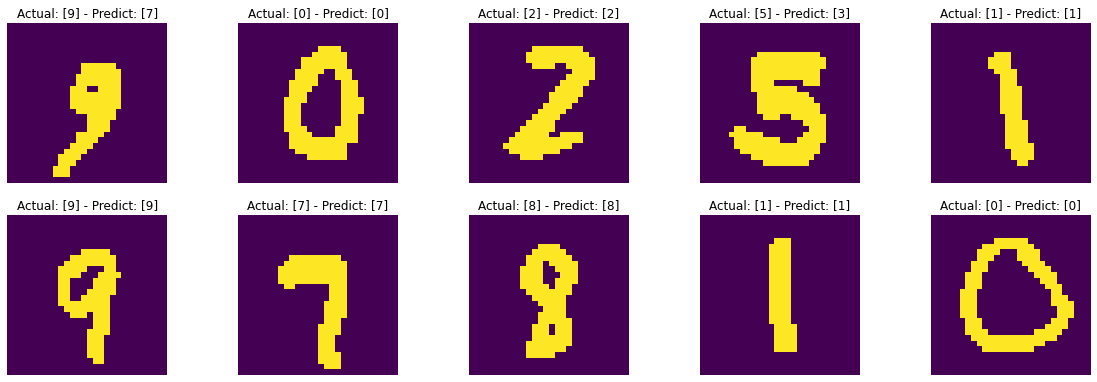

In [62]:
# visualization
fig = plt.figure(figsize=(20, 10))
for i in range(10):  
    ax = fig.add_subplot(3, 5, i+1)
    ax.imshow(test_X[i])
    ax.set_title('Actual: {actual} - Predict: {predict}'.format(actual= test_y[i], predict = predict_result[i]))
    plt.axis('off')

# Evaluation


In [63]:
# convert array into list for visualization
def convert_array_to_list(data):
  new_list = []
  for sublist in data:
    for item in sublist:
      new_list.append(item)
  return new_list

test_y_as_list = convert_array_to_list(test_y)
predict_result_as_list = convert_array_to_list(predict_result)

In [64]:
# put the predict and the actual lavel into confusion matrix
y_actu = pd.Series(test_y_as_list, name='Actual')
y_pred = pd.Series(predict_result_as_list, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred, normalize='index')

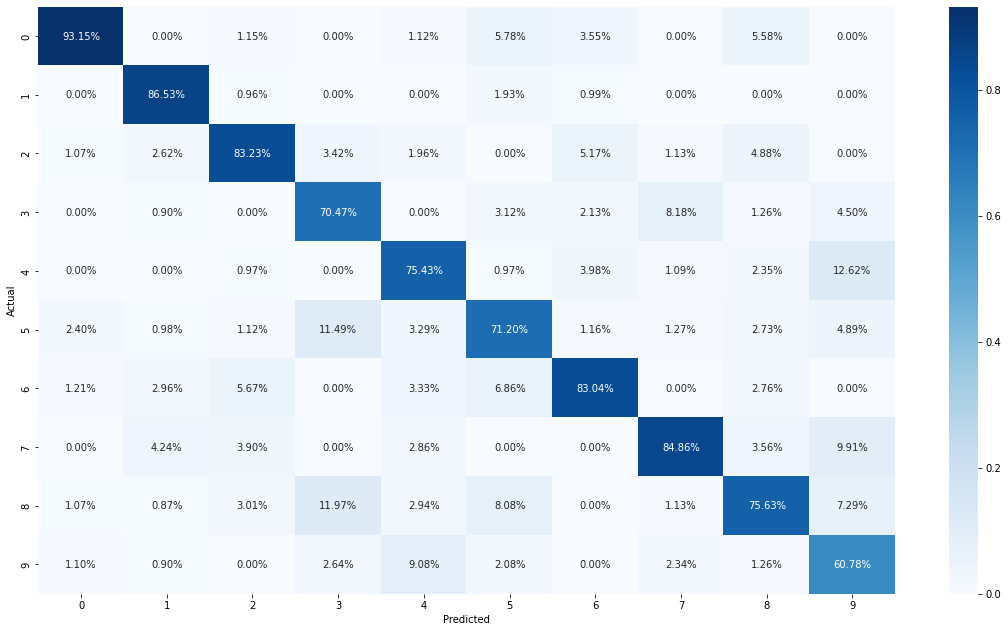

In [65]:
# Print confusion matrix
fig, ax = plt.subplots( figsize=(19.20,10.80) ) 
sns.heatmap(df_confusion/np.sum(df_confusion), annot=True, 
            fmt='.2%', cmap='Blues',  ax=ax)
#plt.savefig('confusion-matrix-test.png', dpi=300)

In [66]:
def overall_accuracy(y_true, y_pred):
        accuracy = np.sum(y_actu == y_pred) / len(y_actu)
        return accuracy
overall_accuracy(y_actu, y_pred)

0.777

# Multinomial (Ineffienct)

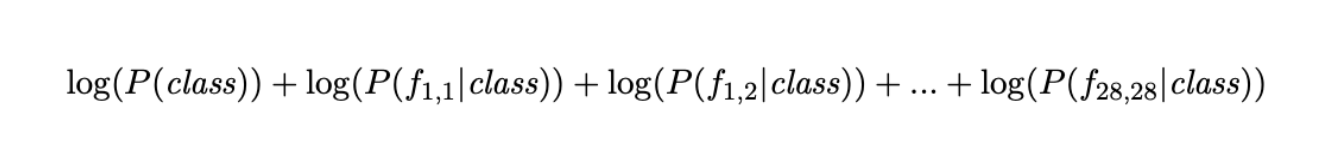

In [67]:
def maximum_posteriori_multinomial(x):
    '''Cong thuc theo phan phoi Multinomial
       x la 1 new training example, (28, 28)
       return 1 vector 1D co 10 phan tu tuong ung voi xac suat
       cua bức ảnh được dự đoán thuộc class thứ c ∈ {0, 1, ..., 9}
    '''
    posteriori = [] # posterior probabilities, size = (10,)
   
    # dimenshion = (10, 1)
    log_P_class = np.log(P_class).reshape(10, 1)

    # (10, 28, 28) 
    log_P_laplace = np.log(P_laplace)

    # lap qua 10 bo loc laplace da tim ra va nhan voi mau moi 
    for y in range(10):
       # ta lấy sum tất cả pixel trong ma trận mẫu mới * ma trận bộ lọc của class thứ y để ra 1 scalar
       # sau đó cộng với xác suất class thứ y xuất hiện 
       convolution =  log_P_class[y] + np.sum( x * log_P_laplace[y] )
       posteriori.append(convolution)              
                                
    return np.array(posteriori) 

In [68]:
def predict_multinomial(X):
    return [maximum_posteriori_multinomial(x).argmax(axis=0) for x in X]
    
predict_result_multinomial = predict_multinomial(test_X)

In [ ]:
predict_result_multinomial

In [70]:
predict_result_multinomial_as_list = convert_array_to_list(predict_result_multinomial)

In [71]:
overall_accuracy(test_y_as_list, predict_result_multinomial_as_list)

0.623